<a href="https://colab.research.google.com/github/quadrater/D7047E/blob/main/D4047E_Lab2_Task_2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Inspiration from + conditioning.
#https://github.com/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.2 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15884622.21it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 481955.64it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4401297.88it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5479013.16it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [ ]:
train_dataloader = DataLoader(train, batch_size=16, shuffle=True)

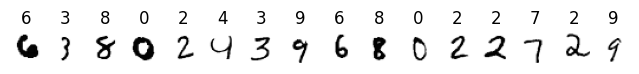

In [ ]:
def display_images_with_labels(images, labels=None):
    """
    Display a grid of images with their corresponding labels.

    Args:
    images (Tensor): A batch of images, shaped (batch_size, channels, height, width).
    labels (Tensor): Corresponding labels for each image.
    """
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images/2, 2.5))

    # Fix broken convention....
    axes = [axes] if num_images == 1 else axes

    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0), cmap='Greys')
        if labels is not None:
          ax.set_title(labels[i].item())
        ax.axis('off')

    plt.show()

x, y = next(iter(train_dataloader))
display_images_with_labels(x, y)



### Conditional U-Net

Implement a basic U-Net model modified to accept an additional conditioning channel. The conditioning is achieved via embeddings associated with each label, which are concatenated with the input images.

### Embeddings

The embeddings are different noise associated with different labels.

###Network Configuration

Construct separate down_layers and up_layers using convolutional layers, defined to progressively downsample and then upsample the input.
Employ Silu (Sigmoid Linear Unit) as the activation function for its smooth non-linearity and efficient gradient propagation.

### Forward Pass

Concatenate the input with label-specific embeddings, enriching the feature space with label-dependent information.


In [ ]:
class ConditionalBasicUNet(nn.Module):
    """A minimal UNet implementation with an extra channel for conditioning."""
    def __init__(self, in_channels=2, out_channels=1):
        super().__init__()
        # Make shift embeddings. Noise!
        self.embeddings = torch.randn(10, 1, 28, 28).to(device)
        self.down_layers = nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)


    def forward(self, x, labels):
        x = torch.cat([x, self.embeddings[labels]], dim=1)
        h = []
        # Setting up layers, keeping output for skip connections i h.
        # Downsample path
        for i, layer in enumerate(self.down_layers):
            x = self.act(layer(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        # Upsample path
        for i, layer in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop()  # Consider using torch.cat([x, h.pop()], dim=1) after adjusting layers
            x = self.act(layer(x))
        return x


In [ ]:
def corrupt(x, amount):
  """Corrupt the input x by mixing it with noise according to amount."""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1)
  return x*(1-amount) + noise*amount

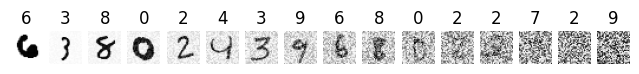

In [ ]:
amount = torch.linspace(0, 1, 16)
noised_x = corrupt(x, amount)

display_images_with_labels(noised_x, y)

Epoch 9. Average loss: 0.014770: 100%|██████████| 10/10 [01:58<00:00, 11.85s/it]


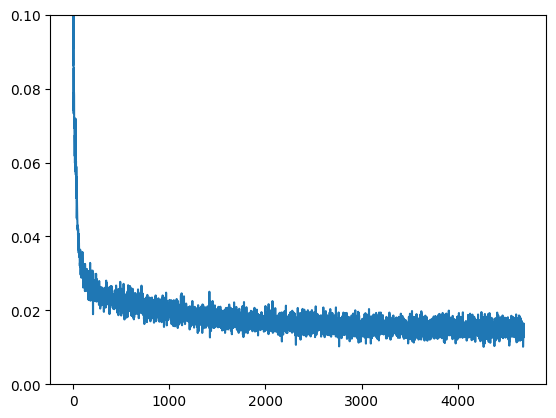

In [ ]:
batch_size = 128
n_epochs = 10

# Reload the dataset with correct batch size.
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

net = ConditionalBasicUNet().to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []

progress = tqdm.tqdm(range(n_epochs))
for epoch in progress:
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, y.to(int).to(device))
        loss = loss_fn(pred, x) # This is a matter of discussion /APN

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)

    progress.set_description(f'Epoch {epoch}. Average loss: {avg_loss:05f}')

plt.plot(losses)
plt.ylim(0, 0.1);

### Noise level

Test the effects of different level of noise on the conditioned outputs.

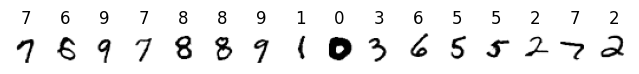

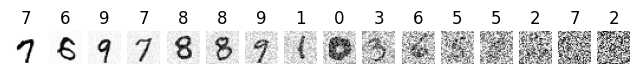

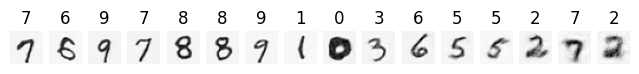

In [ ]:
test_dataloader = DataLoader(test, batch_size=16, shuffle=True)
x, y = next(iter(test_dataloader))

amount = torch.linspace(0, 1, 16)
noised_x = corrupt(x, amount)

with torch.no_grad():
  preds = net(noised_x.to(device), y.to(int).to(device)).detach().cpu()

display_images_with_labels(x, y)
display_images_with_labels(noised_x, y)
display_images_with_labels(preds, y)

### Conditional generation on noise
Use crude scheduling and generated noise conditioned by the noise embeddings. 😎

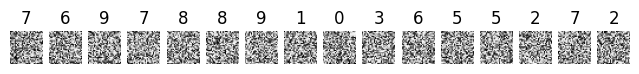

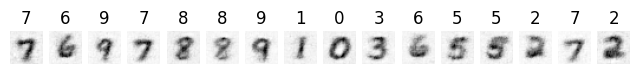

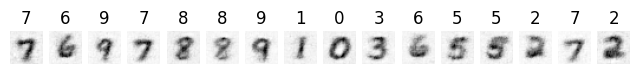

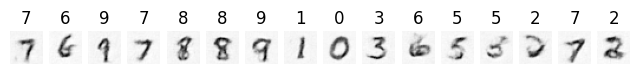

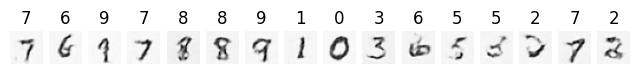

In [ ]:
# Replace the data with noise.
noise = torch.rand_like(x)
x = noise
display_images_with_labels(x, y)

# Very crude scheduling...
steps = 4
for s in range(steps):
    with torch.no_grad():
        preds = net(x.to(device), y.to(device)).detach().cpu()
        display_images_with_labels(preds, y)
        x = preds * (s/steps) + noise * (1 - s/steps)